In [1]:
import cv2
cv2.__version__
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from imutils.object_detection import non_max_suppression

In [2]:
tnet = cv2.dnn.readNet('./text/frozen_east_text_detection.pb')

In [3]:
tnet.getLayerNames()

['resnet_v1_50/conv1/Conv2D',
 'resnet_v1_50/conv1/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/conv1/Relu',
 'resnet_v1_50/pool1/MaxPool',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/Conv2D',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/Conv2D',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/Relu',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/Conv2D',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/Relu',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/Conv2D',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/BatchNorm/FusedBatchNorm',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/add',
 'resnet_v1_50/block1/unit_1/bottleneck_v1/Relu',
 'resnet_v1_50/block1/unit_2/bottleneck_v1/conv1/Conv2D',
 'resnet_v1_50/block1/unit_2/bottleneck_v1/conv1/Bat

In [3]:
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

(159, 318, 3)


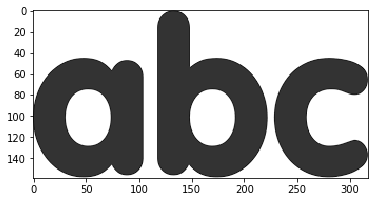

In [4]:
img = cv2.imread('timage_4.png')
print(img.shape)
plt.imshow(img)

In [5]:
(H, W,_) = img.shape
W

318

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 320, 320)


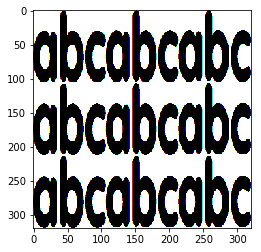

In [6]:
img_blob = cv2.dnn.blobFromImage(img,1.0,(320,320),(123.68,116.78,103.94),swapRB = True,crop=False)
print(img_blob.shape)
plt.imshow(img_blob.reshape(320,320,3))

In [7]:
tnet.setInput(img_blob)
(scores, geometry) = tnet.forward(layerNames)


In [8]:
print(scores.shape)
print(geometry.shape)

(1, 1, 80, 80)
(1, 5, 80, 80)


In [10]:

def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < 0.5:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)


In [11]:
(rects, confidences) = decode_predictions(scores, geometry)


In [12]:
boxes = non_max_suppression(np.array(rects), probs=confidences)
len(boxes[0])

4

In [13]:
startx,starty,endx,endy =  boxes[0]

In [14]:
rW = W / 320.0
rH = H / 320.0

print(rW,rH)

0.99375 0.496875


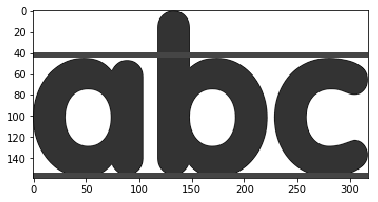

In [15]:
startx = int(startx * rW)
starty = int(starty * rH)
endx = int(endx * rW)
endy = int(endy * rH)



cv2.rectangle(img,(startx,starty),(endx,endy),(69,69,69),3)
plt.imshow(img)

# #post processing 
# dX = int((endx - startx) * 0.0)
# dY = int((endy - starty) * 0.0)

# # apply padding to each side of the bounding box, respectively
# startx = max(0, startx - dX)
# starty = max(0, starty - dY)
# endx = min(W, endx + (dX * 2))
# endy = min(H, endy + (dY * 2))





In [16]:
#video tutorial

cam = cv2.VideoCapture(0)

layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

result = []
while True:
    
    
    ret,frame = cam.read()
    
    
    H,W,_ = frame.shape
    
    
    
#     if cv2.waitKey(1) ==  ord('a'):
        
    #create a blob to feed in d neural network.
    img_blob = cv2.dnn.blobFromImage(frame,1.0,(320,320),(123.68,116.78,103.94),
                                     swapRB = True,crop=False)
    
    tnet.setInput(img_blob)                                 
    
                                     
    # getting predictions 
                                     
    (scores, geometry) = tnet.forward(layerNames)
                                 
     
    #decoding predictions                                  
    (rects, confidences) = decode_predictions(scores, geometry)
    
    #final filtering apply non-max supression
    boxes = non_max_suppression(np.array(rects), probs=confidences)                                 
    
    
    if len(boxes)>0:
        #get the box cordinates
        #modifing the code to detect multiple boxes.
        for n,i in enumerate(boxes):
            
            startx,starty,endx,endy =  i                             
        

            #calculating nomalising ratio                                 
            rW = W / 320.0
            rH = H / 320.0
   
            #de-normalizing the image                                 
            startx = int(startx * rW)
            starty = int(starty * rH)
            endx = int(endx * rW)
            endy = int(endy * rH)
            
            #trying to extract text using tesceract ocr.
            
            #1 extract the roi from frame
            
            roi = frame[starty:endy,startx:endx]
             
            config = ("-l eng --oem 1 --psm 7")
            try:
                text = pytesseract.image_to_string(roi, config=config)
            except:
                print('some stupid error')
            
            
            
            x_text = "".join([c if ord(c) < 122 and ord(c)>=65 else "" for c in text]).strip()
            
            
            cv2.putText(frame, x_text, (startx, starty - 20),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
            
            cv2.rectangle(frame,(startx,starty),(endx,endy),(69,69,69),3)
            
            if cv2.waitKey(1) == ord('q'):
            
                cv2.imwrite('result'+str(n)+'.jpg',frame)
                print('image saved')
    
    cv2.imshow('image',frame)
    
    
    if cv2.waitKey(1) == ord('e'): #enter key
        
        
        print("stopping")
        
        break;

cam.release()        
cv2.destroyAllWindows()


some stupid error
some stupid error
some stupid error
some stupid error
some stupid error
stopping


In [17]:
cv2.imwrite?

In [18]:
ord('.')

46